# Chord classifier


## Packages installation

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
!conda install -c conda-forge ffmpeg libsndfile

In [ ]:
%pip install spleeter

In [4]:
%pip install pandas numpy librosa matplotlib torch torchvision seaborn

In [2]:
%pip install "ray[tune]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.5 MB/s eta 0:00:00


In [5]:
import ray

## Data preprocessing

The purpose of preprocessing step, which is crucial for training the model, is to convert each chord represented as `wav` file into   spectrograms.


In [6]:
import pandas as pd
import os

### Google Colab file management (no need to run outside Colab)

For usage of data in Google Colab, I mount my Google Drive and then copy files from it to the local instance to make processing faster.

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [8]:
os.chdir("/content")

In [9]:
!cp -R "/gdrive/My Drive/chord_classifier/data" "data"

### Data exploration


In [4]:
from pathlib import Path
import os

data_dir = "data"
preprocessed_train_data_dir = Path(os.path.join(data_dir, "preprocessed", "train"))
preprocessed_test_data_dir = Path(os.path.join(data_dir, "preprocessed", "test"))
pretrained_models_dir = Path("pretrained_models")
preprocessed_train_data_dir.mkdir(parents=True, exist_ok=True)
preprocessed_test_data_dir.mkdir(parents=True, exist_ok=True)
pretrained_models_dir.mkdir(parents=True, exist_ok=True)

train_data_dir = data_dir + "/Training"
test_data_dir = data_dir + "/Test"

Show the number of chord recordings available for training and testing

In [2]:
def get_chord_counts(data_dir):
    chord_counts = {}

    for chord in os.listdir(data_dir):
        chord_path = os.path.join(data_dir, chord)
        if os.path.isdir(chord_path):
            chord_counts[chord] = len(os.listdir(chord_path))

    return chord_counts

In [3]:
print(f"Training data chord count {get_chord_counts(train_data_dir)}")
print(f"Testing data chord count {get_chord_counts(test_data_dir)}")

Training data chord count {'Am': 180, 'Bb': 180, 'Em': 180, 'G': 180, 'F': 180, 'Dm': 180, 'C': 180, 'Bdim': 180}
Testing data chord count {'Am': 40, 'Bb': 40, 'Em': 40, 'G': 40, 'F': 40, 'Dm': 40, 'C': 40, 'Bdim': 40}


Show the duration of sounds of chords. It ranges from 1.12 to 16.34 seconds with median about 5 seconds.

In [387]:
import librosa
import pandas as pd

durations = []

for chord in os.listdir(train_data_dir):
    chord_path = os.path.join(train_data_dir, chord)
    if os.path.isdir(chord_path):
        for file in os.listdir(chord_path):
            file_path = os.path.join(chord_path, file)
            y, sr = librosa.load(file_path, sr=None)
            durations.append(librosa.get_duration(y=y, sr=sr))

durations_df = pd.DataFrame(durations, columns=['duration'])
durations_df.describe()

,duration
count,1440.000000
mean,5.631320
std,2.448665
min,1.123563
25%,4.381312
50%,5.048063
75%,6.000000
max,16.343855


A little trick to create an image from a spectrogram with matplotlib and then save it.

In [26]:
import os
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def create_spectrogram(audio_input, sr=None, save_path=None):
    # skip already existing sprectrogram
    if os.path.exists(save_path):
        print(f"Spectrogram  {save_path} already exists. Skipping.")
        return

    # Load the audio file if a path is provided, else use the provided audio data
    if isinstance(audio_input, str):
        y, sr = librosa.load(audio_input, sr=None)
    else:
        y = audio_input
        if sr is None:
            raise ValueError("Sampling rate must be provided with audio data")

    print(f"Creating spectrogram {save_path}")

    # Generate the Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot and save the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format="jpg")
    plt.close()

    return S_dB


In [ ]:
def convert_chords_to_spectrograms(source_dir, destination_dir, durations=[0.4, 0.5, 0.6]):
    for chord in os.listdir(source_dir):
        chord_path = os.path.join(source_dir, chord)
        preprocessed_chord_path = os.path.join(destination_dir, chord)

        if not os.path.exists(preprocessed_chord_path):
            os.makedirs(preprocessed_chord_path)

        if os.path.isdir(chord_path):
            for file in os.listdir(chord_path):
                file_path = os.path.join(chord_path, file)
                y, sr = librosa.load(file_path, sr=None)

                for beat_duration in durations:
                    samples_per_beat = int(beat_duration * sr)

                    for i in range(0, len(y), samples_per_beat):
                        end_frame = i + samples_per_beat
                        if end_frame > len(y):
                            end_frame = len(y)  # Adjust the end frame for the last segment

                        segment = y[i:end_frame]
                        duration_ms = int(beat_duration * 1000)  # Convert to milliseconds for filename
                        save_path = os.path.join(preprocessed_chord_path, f"{os.path.splitext(file)[0]}_{i // samples_per_beat}_{duration_ms}ms.jpg")
                        # Create spectrogram from a segment and save it to disk
                        create_spectrogram(segment, sr, save_path)



Convert train and test data. This is going to take a while.


In [ ]:
convert_chords_to_spectrograms(train_data_dir, preprocessed_train_data_dir)
convert_chords_to_spectrograms(test_data_dir, preprocessed_test_data_dir)

Let's check the number of generated files.

In [5]:
print(f"Training data chord count {get_chord_counts(preprocessed_train_data_dir)}")
print(f"Testing data chord count {get_chord_counts(preprocessed_test_data_dir)}")

Training data chord count {'.DS_Store': 0, 'Am': 6558, 'Bb': 6535, 'Em': 6647, 'G': 6605, 'F': 6416, 'Dm': 6515, 'C': 6555}
Testing data chord count {'.DS_Store': 0, 'Am': 1180, 'Bb': 1185, 'Em': 1317, 'G': 1267, 'F': 1227, 'Dm': 1217, 'C': 1253}


An example of a spectrogram

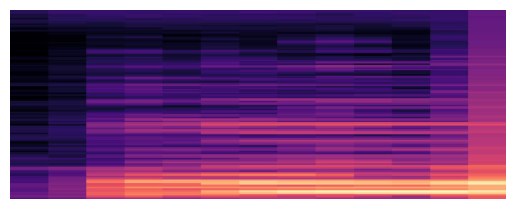

In [27]:
import matplotlib.image as mpimg

image_path = os.path.join(preprocessed_train_data_dir, 'Am', 'Am_acousticguitar_Mari_1_0_400ms.jpg')

img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

## Fine tuning ResNet50


Load the model and enable the last layer for fine tuning. If we have a saved version of the model, we can load its state.

In [9]:
import torch
# use GPU where available
device = "mps" if getattr(torch, 'has_mps', False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

def load_model(saved_model_path=None):
  num_classes = 7 # we have 7 chords in our dataset
  model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

  # replacing the last layer for fine tuning
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, num_classes)


  if saved_model_path:
    model.load_state_dict(torch.load(saved_model_path, map_location=torch.device(device)))

  return model.to(device)


In [11]:
model = load_model()

Categorical mapping of chords so that we could use them as numerical indexes in the neural network but also could decipher it back to actual labels for representation.

In [21]:
chord_labels = ["Am", "Bb", "C", "Dm", "Em", "F", "G"]
label_to_idx = {
    "Am": 0,
    "Bb": 1,
    "C": 2,
    "Dm": 3,
    "Em": 4,
    "F": 5,
    "G": 6,
}

Define our dataset


In [13]:
from PIL import Image
from torch.utils.data import DataLoader, Dataset

class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None, include_labels=True, image_mode="RGB"):
        """
        Args:
            root_dir (string): Directory with all the subdirectories for each label.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.samples = []
        self.label_to_idx = label_to_idx
        self.include_labels = include_labels
        self.image_mode = image_mode

        # Iterate over each subdirectory in root_dir
        for label_dir in os.listdir(root_dir):
            label_dir_full_path = os.path.join(root_dir, label_dir)
            if os.path.isdir(label_dir_full_path):

                # Iterate over each file in the subdirectory
                for file in os.listdir(label_dir_full_path):
                    file_full_path = os.path.join(label_dir_full_path, file)
                    if os.path.isfile(file_full_path):
                        # Append the file path and its label to the samples list
                        self.samples.append((file_full_path, self.label_to_idx[label_dir]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_idx = self.samples[idx]
        img = Image.open(img_path).convert(self.image_mode)

        if self.transform:
            img = self.transform(img)

        if self.include_labels:
            return img, label_idx

        return img


The function to resize the images to the size expected by ResNet (224x224). As the original images are not square, it also pads them with blank space to keep the proportions as they are crucial for a time representation like the spectrogram.

In [16]:
from PIL import Image, ImageOps

def resize_and_pad(spectrogram, target_size=(224, 224)):
    # Calculate the resize ratio and resize the spectrogram
    ratio = min(target_size[0] / spectrogram.width, target_size[1] / spectrogram.height)
    new_size = (int(spectrogram.width * ratio), int(spectrogram.height * ratio))
    spectrogram = spectrogram.resize(new_size, Image.LANCZOS)

    # Calculate padding
    delta_width = target_size[0] - new_size[0]
    delta_height = target_size[1] - new_size[1]
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))

    # Add padding
    return ImageOps.expand(spectrogram, padding)


A function to calculate mean and standard deviation for normalization.


In [104]:
from torch.utils.data import DataLoader
import torch

def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        channels = images.size(1)
        images = images.view(batch_samples, channels, -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std


Transform the data to the input format expected by the network. This step without the normalization as we first need to calculate the mean and standard deviation.


In [105]:
from torchvision import transforms

pre_transform = transforms.Compose([
    transforms.Lambda(resize_and_pad),
    transforms.ToTensor(),
])


The following operation is to calculate mean and std across the training dataset for normalization. It is an expensive operation so this cell is disabled and the following cell contains those values received from a previous calculation.

In [106]:
%%script false --no-raise-error
#| code: true
#| output: false
#} eval: false

pre_dataset = SpectrogramDataset(root_dir=preprocessed_train_data_dir, transform=pre_transform)

pre_loader = DataLoader(pre_dataset, batch_size=64, shuffle=True, num_workers=0)

mean, std = calculate_mean_std(pre_loader)
print(mean, std)


In [18]:
mean = [0.1940, 0.0823, 0.1370]
std = [0.3135, 0.1575, 0.1981]

Now that we have all necessary information, we can fully transform the dataset.

In [19]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Lambda(resize_and_pad),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [22]:
dataset = SpectrogramDataset(root_dir=preprocessed_train_data_dir, transform=transform)
len(dataset)

45831

Create validation dataset

In [110]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])
len(validation_dataset)

9167

The following function is used for testing the model and returns current loss and accuracy. It is used both for hyperparameter tuning feedback and for testing the model on the test dataset.

In [12]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [66]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


In [42]:
max_epochs = 30

The model training loop. It uses checkpoints as the training is a long operation that might be interrupted and it that case we should be able to continue where we left off. It also leverages learning rate scheduler to adjust learning rate during the training to improve convergency.

In [27]:
from ray import train
import tempfile
from ray.train import Checkpoint
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

checkpoint_dir = os.path.join(pretrained_models_dir, "checkpoints")

def train_model(config):
    # optimizer = getattr(torch.optim, config["optimizer"])(model.parameters(), lr=config["lr"])
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    start = 1
    checkpoint = train.get_checkpoint()
    if checkpoint:
        checkpoint = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        start_epoch = checkpoint['epoch'] + 1
        scheduler.load_state_dict(checkpoint['scheduler_state'])

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=config["batch_size"], shuffle=False)

    num_epochs = config.get("epochs", 7)

    for epoch in range(start, num_epochs):
      print(f"Start epoch {epoch}")
      model.train()
      running_loss = 0.0
      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      # validation
      val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
      scheduler.step()

      torch.save({
          'epoch': epoch,
          'model_state': model.state_dict(),
          'optimizer_state': optimizer.state_dict(),
          'scheduler_state': scheduler.state_dict(),
        }, os.path.join(checkpoint_dir, "checkpoint.pt"))

      checkpoint=Checkpoint.from_directory(checkpoint_dir)
      # send data to Ray Tune at each epoch to allow the scheduler to cancel inefficient experiments early
      train.report({"val_loss": val_loss, "accuracy": val_accuracy})


## Hyperparameter tuning

Here I use a Ray Tune scheduler to be able to cut off inefficient experiments early and improve the efficiency of hyperparameter tuning

In [34]:
from ray.tune.schedulers import ASHAScheduler

scheduler = ASHAScheduler(
    metric="val_loss",
    mode="min",
    max_t = max_epochs,
    grace_period=1,
    reduction_factor=2,
)


These are hyperparameters that we are going to choose.

In [52]:
from ray import tune

config = {
    "lr": 0.0151688,
    # "lr": tune.loguniform(1e-2, 1e-1),
    # "batch_size": tune.choice([16, 32, 64]),
    "batch_size": 16,
    "epochs": tune.choice([7, 10, 15, 18, 23, 30]),
    # "optimizer": tune.choice(["Adam", "SGD"]),
    "step_size": tune.choice([5, 10, 20]),
    "momentum": tune.uniform(0.8, 0.99),
}

In [45]:
import ray
ray.shutdown()
ray.init(ignore_reinit_error=True, local_mode=True)

2024-02-06 17:05:24,497	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.9.2


In [46]:
def get_best_params(config, train_model, scheduler, num_samples=10):
    analysis = tune.run(
        train_model,
        config=config,
        num_samples=num_samples,  # Number of times to sample from the hyperparameter space
        resources_per_trial={"cpu": 8},  # Resources per trial
        scheduler=scheduler,
        resume="AUTO"
    )

    return analysis.get_best_config(metric="accuracy", mode="max")

In [68]:
# this is the most successful config received by running hyperparameter tuning on Google Colab
best_config = {'lr': 0.0151688, 'batch_size': 16, 'epochs': 15, 'step_size': 20, 'gamma': 0.9, 'momentum': 0.8621876688576123}

Run this cell to get current best config result

In [53]:
best_config = get_best_params(config, train_model, scheduler, 15)
print("Best config: ", best_config)

2024-02-06 11:08:38,622	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-02-06 11:08:39,573	INFO experiment_state.py:402 -- No local checkpoint was found. Starting a new run...


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-02-06_11-08-39   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 15                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-02-06_11-08-39
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/train_model_2024-02-06_11-08-39`
:task_name:bundle_reservation_check_func


:task_name:bundle_reservation_check_func


:actor_name:ImplicitFunc
:actor_name:train_model

Trial train_model_14cbf_00000 started with configuration:
+--------------------------------------------------+
| Trial train_model_14cbf_00000 config             |
+--------------------------------------------------+
| batch_size                                    16 |
| epochs                                        10 |
| gamma                                        0.9 |
| lr                                       0.01517 |
| momentum                                 0.98965 |
| step_size                                     10 |
+--------------------------------------------------+
Start epoch 1


:actor_name:ImplicitFunc
:actor_name:train_model


Epoch 3/7, Loss: 0.22839996854680028
Save to checkpoint /tmp/tmplghd1973/checkpoint.pt

Trial status: 1 RUNNING
Current time: 2024-02-06 11:22:39. Total running time: 13min 59s
Logical resource usage: 2.0/2 CPUs, 2560.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+------------------------------------------------------------------------------------+
| Trial name                status       epochs     step_size     gamma     momentum |
+------------------------------------------------------------------------------------+
| train_model_14cbf_00000   RUNNING          10            10       0.9     0.989646 |
+------------------------------------------------------------------------------------+

Trial train_model_14cbf_00000 finished iteration 1 at 2024-02-06 11:22:39. Total running time: 13min 59s
+--------------------------------------------------+
| Trial train_model_14cbf_00000 result             |
+--------------------------------------------------+
| checkpoint_dir_name                    

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:train_model


Epoch 4/7, Loss: 0.17673377506232385
Save to checkpoint /tmp/tmpex0l1z5w/checkpoint.pt

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-02-06 11:38:20. Total running time: 29min 41s
Logical resource usage: 4.0/2 CPUs, 5120.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         epochs     step_size     gamma     momentum     iter     total time (s)     val_loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_14cbf_00001   RUNNING            23            10       0.9     0.857647                                                       |
| train_model_14cbf_00000   TERMINATED         10            10       0.9     0.989646        2            928.769     0.357619     0.870106 |
+----------

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:train_model


Epoch 6/7, Loss: 0.14126097518839542
Save to checkpoint /tmp/tmpez4cgmln/checkpoint.pt

Trial status: 2 TERMINATED | 1 RUNNING
Current time: 2024-02-06 12:09:46. Total running time: 1hr 1min 6s
Logical resource usage: 2.0/2 CPUs, 2560.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         epochs     step_size     gamma     momentum     iter     total time (s)     val_loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_14cbf_00002   RUNNING            15            20       0.9     0.862188                                                       |
| train_model_14cbf_00000   TERMINATED         10            10       0.9     0.989646        2            928.769     0.357619     0.870106 |
| train_m

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:train_model


Epoch 3/15, Loss: 0.22712422775793484
Save to checkpoint /tmp/tmpuuwok2se/checkpoint.pt

Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2024-02-06 12:26:50. Total running time: 1hr 18min 10s
Logical resource usage: 2.0/2 CPUs, 2560.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         epochs     step_size     gamma     momentum     iter     total time (s)     val_loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_14cbf_00003   RUNNING            18            20       0.1     0.871538                                                       |
| train_model_14cbf_00000   TERMINATED         10            10       0.9     0.989646        2            928.769     0.357619     0.870106 |
| trai

2024-02-06 13:58:45,000	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


Epoch 11/18, Loss: 0.12940649024106132
Save to checkpoint /tmp/tmphi1n7f4w/checkpoint.pt


2024-02-06 14:08:42,374	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)



Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2024-02-06 14:08:42. Total running time: 3hr 0min 2s
Logical resource usage: 2.0/2 CPUs, 2560.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         epochs     step_size     gamma     momentum     iter     total time (s)     val_loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_14cbf_00003   RUNNING            18            20       0.1     0.871538       10           5585.81      0.167346     0.934998 |
| train_model_14cbf_00000   TERMINATED         10            10       0.9     0.989646        2            928.769     0.357619     0.870106 |
| train_model_14cbf_00001   TERMINATED         23            10       0.9     0.857647        4 

### Training the model with optimal hyperparameters


In [23]:
train_model(best_config)

/usr/local/lib/python3.10/dist-packages/ray/train/_internal/session.py:638: UserWarning: `get_checkpoint` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


Start epoch 1
Epoch 2/15, Loss: 0.5091636091942882
Save to checkpoint /tmp/tmprzl5fac7/checkpoint.pt


/usr/local/lib/python3.10/dist-packages/ray/train/_internal/session.py:638: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


Start epoch 2
Epoch 3/15, Loss: 0.2262736892707978
Save to checkpoint /tmp/tmpd3kgzwm5/checkpoint.pt
Start epoch 3
Epoch 4/15, Loss: 0.18148053778454445
Save to checkpoint /tmp/tmphz2ic17h/checkpoint.pt
Start epoch 4
Epoch 5/15, Loss: 0.15612309563855048
Save to checkpoint /tmp/tmpmuy4kuvp/checkpoint.pt
Start epoch 5
Epoch 6/15, Loss: 0.14424184967610248
Save to checkpoint /tmp/tmp_499rf60/checkpoint.pt
Start epoch 6
Epoch 7/15, Loss: 0.1276284369279869
Save to checkpoint /tmp/tmp40vtppi9/checkpoint.pt
Start epoch 7
Epoch 8/15, Loss: 0.11452750454196128
Save to checkpoint /tmp/tmp2hzzazzw/checkpoint.pt
Start epoch 8
Epoch 9/15, Loss: 0.11665851295976591
Save to checkpoint /tmp/tmpkd98t4_m/checkpoint.pt
Start epoch 9
Epoch 10/15, Loss: 0.10920110530014164
Save to checkpoint /tmp/tmpsgcbymg3/checkpoint.pt
Start epoch 10
Epoch 11/15, Loss: 0.10262493730207822
Save to checkpoint /tmp/tmpsu9cxt5u/checkpoint.pt
Start epoch 11
Epoch 12/15, Loss: 0.09575605211894765
Save to checkpoint /tmp/tmp

In [23]:
torch.save(model.state_dict(), os.path.join(pretrained_models_dir, f"chord_classifier.pth"))

## Transfer Learning

Load the model, replace the last ResNet50 layer with an identity function that will just return features without changes and switch to evaluation mode.

In [20]:
import os

model = load_model(os.path.join(pretrained_models_dir, "chord_classifier_v3.pth"))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [133]:
model.fc = nn.Identity()

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Create a custom neural network which will accept features from pre-trained and fine tuned ResNet50 to make final classifications. This will allow for more flexibility in tuning the architecture for this particular task.

In [39]:
import torch.nn as nn

class ChordClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)

        # Final layer
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

Extract features using pre-trained and fine-tuned ResNet50 and save them into a HDF5 file on disk for training the classifier.

In [37]:
import h5py
import numpy as np
import torch


def create_h5_dataset(data_loader, file_name):
    with h5py.File(file_name, 'w') as h5f:
        for i, (inputs, labels) in enumerate(data_loader):
            print(f"Processed {i} of {len(data_loader)}")
            inputs = inputs.to(device)
            with torch.no_grad():
                output = model(inputs)

            # Convert to numpy and write to disk
            features_batch = output.cpu().detach().numpy()
            labels_batch = labels.numpy()

            # Create datasets for the first batch and then append for subsequent batches
            if i == 0:
                h5f.create_dataset('features', data=features_batch, maxshape=(None, features_batch.shape[1]), chunks=True)
                h5f.create_dataset('labels', data=labels_batch, maxshape=(None,), chunks=True)
            else:
                h5f['features'].resize((h5f['features'].shape[0] + features_batch.shape[0]), axis=0)
                h5f['features'][-features_batch.shape[0]:] = features_batch
                h5f['labels'].resize((h5f['labels'].shape[0] + labels_batch.shape[0]), axis=0)
                h5f['labels'][-labels_batch.shape[0]:] = labels_batch

In [42]:
train_features_set_file_name = "features_labels.h5"

In [336]:
train_dataset = SpectrogramDataset(root_dir=preprocessed_train_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

create_h5_dataset(train_loader, train_features_set_file_name)

Processed 0 of 359


KeyboardInterrupt: 

In [34]:
import h5py
import torch
from torch.utils.data import TensorDataset, DataLoader

def load_dataset_from_file(file_name):
    # Load features and labels
    with h5py.File(file_name, 'r') as hf:
        features = hf['features'][:]
        labels = hf['labels'][:]

    features = torch.tensor(features, dtype=torch.float)
    labels = torch.tensor(labels, dtype=torch.long)

    return features, labels

In [43]:
features, labels = load_dataset_from_file(train_features_set_file_name)

Split the data into training and validation sets

In [44]:
from sklearn.model_selection import train_test_split

features_train, features_val, labels_train, labels_val = train_test_split(
    features, labels, test_size=0.2, random_state=42)

Create datasets

In [45]:
train_features_dataset = TensorDataset(features_train, labels_train)
val_features_dataset = TensorDataset(features_val, labels_val)

print(len(train_features_dataset), len(val_features_dataset))

36664 9167


Train and validate

In [46]:
classifier_model = ChordClassifier(input_size=features.shape[1], num_classes=len(torch.unique(labels)))


In [47]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.02, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

def train_classifier(config, saved_state=None):
    criterion = nn.CrossEntropyLoss()
    epochs = config["epochs"]

    train_loader = DataLoader(train_features_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_features_dataset, batch_size=config["batch_size"], shuffle=False)

    start_epoch = 0
    if saved_state:
        classifier_model.load_state_dict(saved_state["model_state"])
        optimizer.load_state_dict(saved_state["optimizer_state"])
        start_epoch = saved_state["epoch"] + 1
        scheduler.load_state_dict(saved_state['scheduler_state'])

    for epoch in range(start_epoch, epochs):
        classifier_model.train()
        running_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = classifier_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        val_loss, val_accuracy = evaluate_model(classifier_model, val_loader, criterion)

        scheduler.step()
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader)}, '
              f'Val Loss: {val_loss}, Val Acc: {val_accuracy}, LR: {scheduler.get_last_lr()}')

In [49]:
loaded_state = torch.load(os.path.join(pretrained_models_dir, f"classifier_model_1.pth"), map_location='cpu')

In [92]:
train_classifier({"lr": 0.02, "batch_size": 16, "epochs": 50})


Epoch 1/50, Train Loss: 0.23735626311600558, Val Loss: 0.12178923281807867, Val Acc: 0.9523290062179557, LR: [0.02]
Epoch 2/50, Train Loss: 0.23195401705763438, Val Loss: 0.12735550466037587, Val Acc: 0.9500381804298026, LR: [0.02]
Epoch 3/50, Train Loss: 0.2296596721390323, Val Loss: 0.1272991283083468, Val Acc: 0.9517835715064906, LR: [0.02]
Epoch 4/50, Train Loss: 0.23493095698438002, Val Loss: 0.11519019630748756, Val Acc: 0.956256136140504, LR: [0.02]
Epoch 5/50, Train Loss: 0.2193853132250831, Val Loss: 0.11866237428900887, Val Acc: 0.9544016581215229, LR: [0.002]
Epoch 6/50, Train Loss: 0.16454986898269752, Val Loss: 0.11125616238512813, Val Acc: 0.957019744736555, LR: [0.002]
Epoch 7/50, Train Loss: 0.14588923182897823, Val Loss: 0.10729377336309473, Val Acc: 0.9583287880440712, LR: [0.002]
Epoch 8/50, Train Loss: 0.13959562794375943, Val Loss: 0.10660233608558091, Val Acc: 0.9580015272171921, LR: [0.002]
Epoch 9/50, Train Loss: 0.14099739584040366, Val Loss: 0.1064235230254859

In [84]:
state = {
    'epoch': 40,
    'model_state': classifier_model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'scheduler_state': scheduler.state_dict(),
}

torch.save(state, os.path.join(pretrained_models_dir, f"classifier_model_1.pth"))


## Testing the model

Optionally load the model from a saved state. If plan to continue training, load optimizer and scheduler states as well.

In [51]:
classifier_model.load_state_dict(loaded_state['model_state'])
# optimizer.load_state_dict(state['optimizer_state'])
# scheduler.load_state_dict(state['scheduler_state'])

<All keys matched successfully>

Use the same approach as we used for creating training and validation datasets to generate test dataset.

In [32]:
test_features_set_file_name = "features_labels_test.h5"

In [56]:
dataset = SpectrogramDataset(root_dir=preprocessed_test_data_dir, transform=transform)
test_loader = DataLoader(dataset, batch_size=128, shuffle=False)



In [ ]:
create_h5_dataset(test_loader, test_features_set_file_name)

In [35]:
classifier_features, classifier_labels = load_dataset_from_file(test_features_set_file_name)

test_classifier_dataset = TensorDataset(classifier_features, classifier_labels)
test_classifier_loader = DataLoader(test_classifier_dataset, batch_size=32, shuffle=False)
len(test_classifier_dataset)

8646

In [36]:
# todo: should get input into ResNet50 and then process in classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def get_metrics(model_to_test, data_loader):
    model_to_test.eval()

    all_predictions = []
    all_targets = []

    batch_count = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            batch_count += 1
            print("handle batch", batch_count)
            inputs = inputs.to(device)
            outputs = model_to_test(inputs)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')
    conf_matrix = confusion_matrix(all_targets, all_predictions, labels=range(len(chord_labels)))

    return accuracy, precision, recall, f1, conf_matrix



In [52]:
classifier_model

ChordClassifier(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=256, out_features=7, bias=True)
)

To test Classifier, we wrap it into ResNet50 model to serve extracted features as input.

In [53]:
classifier_accuracy, classifier_precision, classifier_recall, classifier_f1, classifier_conf_matrix = get_metrics(classifier_model, test_classifier_loader)

handle batch 1
handle batch 2
handle batch 3
handle batch 4
handle batch 5
handle batch 6
handle batch 7
handle batch 8
handle batch 9
handle batch 10
handle batch 11
handle batch 12
handle batch 13
handle batch 14
handle batch 15
handle batch 16
handle batch 17
handle batch 18
handle batch 19
handle batch 20
handle batch 21
handle batch 22
handle batch 23
handle batch 24
handle batch 25
handle batch 26
handle batch 27
handle batch 28
handle batch 29
handle batch 30
handle batch 31
handle batch 32
handle batch 33
handle batch 34
handle batch 35
handle batch 36
handle batch 37
handle batch 38
handle batch 39
handle batch 40
handle batch 41
handle batch 42
handle batch 43
handle batch 44
handle batch 45
handle batch 46
handle batch 47
handle batch 48
handle batch 49
handle batch 50
handle batch 51
handle batch 52
handle batch 53
handle batch 54
handle batch 55
handle batch 56
handle batch 57
handle batch 58
handle batch 59
handle batch 60
handle batch 61
handle batch 62
handle batch 63
h

In [94]:
print(classifier_accuracy, classifier_precision, classifier_recall, classifier_f1)

0.8952116585704372 0.9021203424003879 0.8948218050071169 0.8961219730887766


Need to reload the ResNet50 model to restore the last layer for comparison.

In [54]:
import os

model = load_model(os.path.join(pretrained_models_dir, "chord_classifier_v3.pth"))
model.to(device)
print(model.fc)

Linear(in_features=2048, out_features=7, bias=True)


In [57]:
accuracy, precision, recall, f1, conf_matrix = get_metrics(model, test_loader)
print(accuracy, precision, recall, f1)

handle batch 1
handle batch 2
handle batch 3
handle batch 4
handle batch 5
handle batch 6
handle batch 7
handle batch 8
handle batch 9
handle batch 10
handle batch 11
handle batch 12
handle batch 13
handle batch 14
handle batch 15
handle batch 16
handle batch 17
handle batch 18
handle batch 19
handle batch 20
handle batch 21
handle batch 22
handle batch 23
handle batch 24
handle batch 25
handle batch 26
handle batch 27
handle batch 28
handle batch 29
handle batch 30
handle batch 31
handle batch 32
handle batch 33
handle batch 34
handle batch 35
handle batch 36
handle batch 37
handle batch 38
handle batch 39
handle batch 40
handle batch 41
handle batch 42
handle batch 43
handle batch 44
handle batch 45
handle batch 46
handle batch 47
handle batch 48
handle batch 49
handle batch 50
handle batch 51
handle batch 52
handle batch 53
handle batch 54
handle batch 55
handle batch 56
handle batch 57
handle batch 58
handle batch 59
handle batch 60
handle batch 61
handle batch 62
handle batch 63
h

In [59]:
print(f"ResNet50 Accuracy: {accuracy}, Classifier Accuracy: {classifier_accuracy}")
print(f"ResNet50 Precision: {precision}, Classifier Precision: {classifier_precision}")
print(f"ResNet50 Recall: {recall}, Classifier Recall: {classifier_recall}")
print(f"ResNet50 F1 Score: {f1}, Classifier F1 Score {classifier_f1}")

ResNet50 Accuracy: 0.8957899606754569, Classifier Accuracy: 0.8939393939393939
ResNet50 Precision: 0.9045474853508028, Classifier Precision: 0.9004375573274704
ResNet50 Recall: 0.8953034375710812, Classifier Recall: 0.8934810910703527
ResNet50 F1 Score: 0.8971718566412676, Classifier F1 Score 0.8947448434748326


In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(conf_matrix1, conf_matrix2, labels, title1='Confusion Matrix 1', title2='Confusion Matrix 2'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

    # Plot first confusion matrix
    sns.heatmap(conf_matrix1, annot=True, fmt='g', ax=ax[0], xticklabels=labels, yticklabels=labels, cmap='viridis')
    ax[0].set_title(title1)
    ax[0].set_xlabel('Predicted labels')
    ax[0].set_ylabel('True labels')

    # Plot second confusion matrix
    sns.heatmap(conf_matrix2, annot=True, fmt='g', ax=ax[1], xticklabels=labels, yticklabels=labels, cmap='viridis')
    ax[1].set_title(title2)
    ax[1].set_xlabel('Predicted labels')
    ax[1].set_ylabel('True labels')

    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()


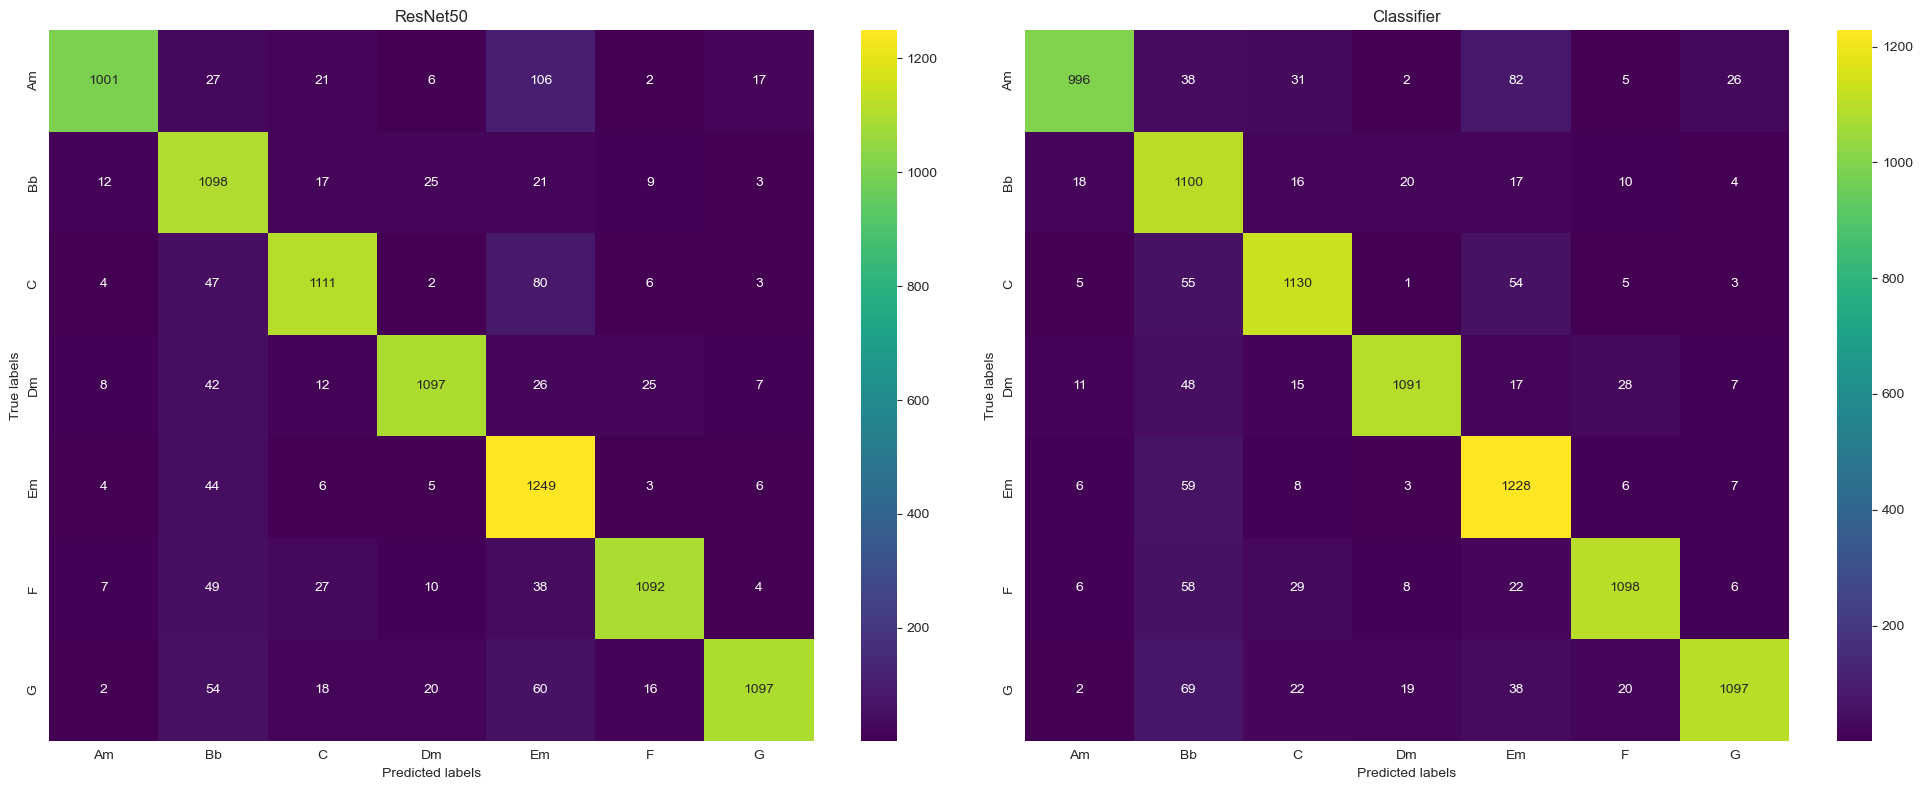

In [95]:
plot_confusion_matrices(conf_matrix, classifier_conf_matrix, chord_labels, "ResNet50", "Classifier")


## Track splitting


This can be skipped if the track is already separated

Adjust the values of the variables below to try the model on a different song uploaded to the songs directory.

In [157]:
songs_dir = "songs"
separated_songs_dir = os.path.join(songs_dir, "separated")
song_file_name = "Have-You-Ever-Seen-The-Rain"
song_path = os.path.join(songs_dir, song_file_name + ".mp3")

Extracting the guitar track from the uploaded song. Let's check this feature on the Have You Ever Seen The Rain by Creedence Clearwater Revival which has a distinctive guitar track.


In [ ]:
from IPython.display import Audio

Audio(song_path)


Spleeter will divide the song into 4 separate tracks: bass, drums, vocals and other. The guitar will be contained in "other".

In [ ]:
import subprocess

command = f"spleeter separate -p spleeter:4stems -o {separated_songs_dir} {song_path}"
subprocess.run(command, shell=True)

In [ ]:
guitar_track_path = os.path.join(separated_songs_dir, song_file_name, "other.mp3")

Audio(guitar_track_path)


## Generating spectrograms from the extracted track


In [158]:
output_dir = Path(os.path.join("data", "extracted", song_file_name))

The following function will process each segment of a track and convert it to a spectrogram. The spectrogram will be returned to be used as input to CNN and also will be saved to disk so that if we want to process the same track again, we could use existing data.

The following function detects beat length and generates a spectrogram for each beat. Currently, it returns an array of spectrograms. Later on, predictions of a chord with CNN will be plugged in and it will return a list of predictions.

In [ ]:
import librosa

def process_track(audio_path, output_dir):
    y, sr = librosa.load(audio_path, sr=None)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    print(f"Track tempo is {tempo}")
    beat_duration = 60.0 / tempo  # Duration of a beat in seconds

    print(f"Beat duration is {beat_duration} seconds")

    # Calculate the number of samples per beat
    samples_per_beat = int(beat_duration * sr)

    print(f"Samples per beat: {samples_per_beat}")

    spectrograms = []
    for i in range(0, len(y), samples_per_beat):
        end_frame = i + samples_per_beat
        if end_frame > len(y):
            end_frame = len(y)  # Adjust the end frame for the last segment

        segment = y[i:end_frame]
        filename = f'spectrogram_{i // samples_per_beat}.jpg'
        print(f"Create spectrogram {filename}")
        spectrogram = create_spectrogram(segment, sr, os.path.join(output_dir, filename))
        spectrograms.append(spectrogram)

    return spectrograms


To keep things simple, we will consider that the track already processed if the directory with the song name already exists. We can implement more sophisticated and robust checks like file hash sum later.

In [ ]:
try:
    if os.path.exists(output_dir):
        print("The track is already processed", output_dir)
    else:
        os.makedirs(output_dir)
        print("Processing track", output_dir)
        spectrograms = process_track(guitar_track_path, output_dir)

        print(spectrograms[:10])
except Exception as e:
    print(e)
    os.removedirs(output_dir)


Let's visualize an example of generated spectrogram

In [ ]:
import matplotlib.image as mpimg

files = os.listdir(output_dir)
image_path = os.path.join(output_dir, files[50])

print(f"Displaying the image at {image_path}")

img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


## Inference


In [159]:
from PIL import Image

def load_spectrogram(file_path):
    image = Image.open(file_path).convert('RGB')
    return transform(image)

Switch to evaluation mode and convert logits to probabilities using softmax


In [160]:
import torch

# Ensure the model is in evaluation mode
model.eval()
classifier_model.eval()

# Define the softmax function
softmax = torch.nn.Softmax(dim=1)

Sort spectrograms by file name as it contains its order number. We need to have it ordered to be able to output it aligned with track timeline.

In [171]:
output_dir

PosixPath('data/extracted/Have-You-Ever-Seen-The-Rain')

In [172]:
import os

# List all jpg files in the output directory
file_names = [file for file in os.listdir(output_dir) if file.endswith('.jpg')]

# Sort the file names (natural sort or simple alphanumeric sort)
file_names.sort(key=lambda f: int(f.split('_')[-1].split('.')[0]))

spectrograms = [load_spectrogram(os.path.join(output_dir, file)) for file in file_names]

Make predictions for each spectrogram. For each prediction we get top N results. We also map them to labels for output.

In [173]:
index_to_label = {v: k for k,v in label_to_idx.items()}

N = 3  # Number of top predictions

top_labels_all = []
top_confidences_all = []

for spectrogram in spectrograms:
    # make sure spectrograms are on the same device as the model, otherwise there will be input type mismatch
    spectrogram = spectrogram.to(device)
    # Apply the model and get the prediction
    output = classifier_model(model(spectrogram.unsqueeze(0)))
    # Clip the output to prevent large values dominating the output and allow more stable probabilities
    output_clipped = torch.clamp(output, min=10, max=20)
    probabilities = softmax(output)

    # Get the top N predictions
    top_probs, top_preds = torch.topk(probabilities, N, dim=1)

    # Convert to labels and confidences
    top_labels = [index_to_label[pred.item()] for pred in top_preds[0]]
    top_confidences = [prob.item() for prob in top_probs[0]]

    top_labels_all.append(top_labels)
    top_confidences_all.append(top_confidences)

## Output

* For each beat, we get top N predictions
* Low confidence predictions with threshold lower than 0.3 will be discarded
* We will consider two adjacents beats at once. First, chords that appear in both beats predictions will be chosen. If there are several such chords, then the chord with the highest average confidence will be chosen.

In [156]:
for file, labels, confidences in zip(file_names[:20], top_labels_all[:20], top_confidences_all[:20]):
    print(f"{file}:")
    for label, confidence in zip(labels, confidences):
        print(f"  {label}: {confidence:.4f}")

spectrogram_0.jpg:
  Dm: 0.9997
  Am: 0.0001
  Bb: 0.0001
spectrogram_1.jpg:
  G: 0.5002
  Dm: 0.2056
  Am: 0.1847
spectrogram_2.jpg:
  C: 0.9649
  G: 0.0204
  Em: 0.0066
spectrogram_3.jpg:
  F: 0.9695
  Dm: 0.0069
  Am: 0.0061
spectrogram_4.jpg:
  F: 0.9978
  Dm: 0.0012
  Bb: 0.0003
spectrogram_5.jpg:
  Dm: 0.6307
  Am: 0.1745
  F: 0.1178
spectrogram_6.jpg:
  Dm: 0.7794
  Am: 0.1588
  C: 0.0278
spectrogram_7.jpg:
  C: 0.8063
  Bb: 0.0982
  Em: 0.0483
spectrogram_8.jpg:
  F: 0.6600
  C: 0.1570
  Bb: 0.0719
spectrogram_9.jpg:
  F: 0.9992
  G: 0.0002
  Am: 0.0002
spectrogram_10.jpg:
  F: 0.6102
  Dm: 0.2326
  Bb: 0.1181
spectrogram_11.jpg:
  Dm: 0.9946
  Am: 0.0037
  Bb: 0.0009
spectrogram_12.jpg:
  C: 0.9786
  Am: 0.0179
  Dm: 0.0015
spectrogram_13.jpg:
  C: 0.2736
  G: 0.2381
  Em: 0.2117
spectrogram_14.jpg:
  F: 0.3196
  G: 0.1377
  C: 0.1360
spectrogram_15.jpg:
  F: 0.9936
  Am: 0.0024
  Bb: 0.0012
spectrogram_16.jpg:
  Dm: 0.9910
  Bb: 0.0036
  F: 0.0025
spectrogram_17.jpg:
  Dm: 0.

In [174]:
def map_label_to_confidence(labels, confidences):
    return {label: confidence for label, confidence in zip(labels, confidences)}

In [175]:
def get_with_max_confidence(common_labels, prev_labels_to_confidence, labels_to_confidence):
    highest_conf_label = None
    highest_confidence = 0

    for label in common_labels:
        avg_conf = (prev_labels_to_confidence.get(label, 0) + labels_to_confidence.get(label, 0)) / 2
        if avg_conf > highest_confidence:
            highest_confidence = avg_conf
            highest_conf_label = label

    return highest_conf_label, highest_confidence

In [176]:
def process_chord_predictions(top_labels_all, top_confidences_all, confidence_threshold=0.3):
    chord_predictions = []

    for i in range(1, len(top_labels_all), 2):
        prev_labels = top_labels_all[i - 1]
        labels = top_labels_all[i]
        prev_confidences = top_confidences_all[i - 1]
        confidences = top_confidences_all[i]

        prev_labels_to_confidence = map_label_to_confidence(prev_labels, prev_confidences)
        labels_to_confidence = map_label_to_confidence(labels, confidences)

        # Filter labels by confidence threshold
        prev_filtered = {label: conf for label, conf in prev_labels_to_confidence.items() if conf >= confidence_threshold}
        filtered = {label: conf for label, conf in labels_to_confidence.items() if conf >= confidence_threshold}

        common_labels = set(prev_filtered.keys()).intersection(filtered.keys())

        if common_labels:
            chosen_label, chosen_confidence = get_with_max_confidence(common_labels, prev_labels_to_confidence, labels_to_confidence)
        else:
            # Combine and sort all labels by confidence, regardless of threshold, if no common labels meet the threshold
            all_labels_confidences = list(prev_labels_to_confidence.items()) + list(labels_to_confidence.items())
            chosen_label, chosen_confidence = max(all_labels_confidences, key=lambda x: x[1])

        chord_predictions.append((chosen_label, chosen_confidence))

    return chord_predictions

In [177]:
chord_predictions = process_chord_predictions(top_labels_all, top_confidences_all)
print(chord_predictions)

[('Am', 0.9994567930698395), ('Am', 0.9997973442077637), ('F', 0.9999176263809204), ('F', 0.9999935030937195), ('C', 0.7847565114498138), ('C', 0.9994007647037506), ('G', 0.9513749480247498), ('Em', 0.9840201139450073), ('Em', 0.6527310609817505), ('C', 0.959940493106842), ('Em', 0.6284860670566559), ('Am', 0.6261861324310303), ('C', 0.5409777164459229), ('C', 0.6439778506755829), ('C', 0.8367093205451965), ('C', 0.7113013714551926), ('C', 0.9978026151657104), ('C', 0.9638011753559113), ('C', 0.8660220205783844), ('C', 0.8355092108249664), ('G', 0.9965192079544067), ('G', 0.9982003271579742), ('G', 0.9985175132751465), ('G', 0.9995587170124054), ('G', 0.9995027780532837), ('C', 0.9992209672927856), ('C', 0.9675560295581818), ('C', 0.997273862361908), ('C', 0.9964517951011658), ('C', 0.9408496022224426), ('C', 0.883021891117096), ('C', 0.9974306523799896), ('C', 0.9905152022838593), ('C', 0.8912930488586426), ('C', 0.9487403035163879), ('C', 0.9851056933403015), ('F', 0.9862682819366455

Combine predictions into a chord sequence.

In [178]:
combined_predictions = []

# Initialize the previous chord variable with None
prev_chord = None

# Iterate through each prediction
for chord, confidence in chord_predictions:
    # Check if the current chord is different from the previous chord
    if chord != prev_chord:
        # If it's different, append it to the combined list
        combined_predictions.append(chord)
        # Update the previous chord
        prev_chord = chord

In [179]:
from IPython.display import display, HTML

def display_chords(chord_predictions):
    # Define a color scheme for each chord
    chord_colors = {
        "Am": "#FFD700",  # Gold
        "Bb": "#FF4500",  # OrangeRed
        "Bdim": "#1E90FF",  # DodgerBlue
        "C": "#32CD32",  # LimeGreen
        "Dm": "#BA55D3",  # MediumOrchid
        "Em": "#FF69B4",  # HotPink
        "F": "#00CED1",  # DarkTurquoise
        "G": "#FFA500",  # Orange
    }

    # Start the HTML string for output
    output = "<div style='display: flex; flex-wrap: wrap;'>"

    # Counter to keep track of chords per line
    chords_per_line = 0

    for i, chord in enumerate(chord_predictions, start=1):
        # Get the color for the current chord
        color = chord_colors.get(chord, "grey")  # Default to grey if chord not found

        # Create a div for the chord with the specific background color and white text for contrast
        output += f"<div style='color: white; margin: 5px; padding: 10px; background-color: {color}; width: 100px; text-align: center;'>{chord}</div>"

        # Increment the counter
        chords_per_line += 1

        # Check if we've reached 4 chords or the end of the list, then reset counter and add a line break
        if chords_per_line == 4 or i == len(chord_predictions):
            output += "<div style='flex-basis: 100%; height: 0;'></div>"  # This creates a line break in flexbox
            chords_per_line = 0

    # Close the HTML string
    output += "</div>"

    # Display the HTML in the Jupyter Notebook
    display(HTML(output))


In [180]:
display_chords(combined_predictions)